In [1]:
%config IPCompleter.greedy=True

# En este módulo se realiza la limpieza de datos y se exportan dentro de este mismo directorio "Clean datasets"

#### Imports

In [2]:
import pandas as pd
import numpy as np
from numpy import isnan
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

## Carga de data set
Dataset obtenido en http://medata.gov.co/dataset/intento-de-suicidio

Como primera tarea y antes de cargar los datos, fueron borrados manualmente(editor de texto) todos aquellos valores que se presetaran como SD(sin datos) para facilitar el procesado de los datos en siguientes pasos. SD-> null (nan)

Ya cargados los datos se procede a cambiar los titulos del dataset, ya que originalmente todos incluian el nombre de la base de datos, esto con el fin de trabajar con mayor facilidad



In [3]:
df_suicidio=pd.read_csv("sivigila_intsuicidio.csv", delimiter = ';')
df_suicidio.info()

titles = df_suicidio.columns
arr = []
for i in titles:
    arr.append(i[21:]) #Eliminar 'sivigila_intsuicidio.'
    
df_suicidio.columns = arr
df_suicidio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11336 entries, 0 to 11335
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sivigila_intsuicidio.id                  11336 non-null  int64  
 1   sivigila_intsuicidio.semana              11336 non-null  int64  
 2   sivigila_intsuicidio.edad_               11336 non-null  float64
 3   sivigila_intsuicidio.uni_med_            11336 non-null  int64  
 4   sivigila_intsuicidio.sexo_               11336 non-null  object 
 5   sivigila_intsuicidio.nombre_barrio       11336 non-null  object 
 6   sivigila_intsuicidio.comuna              11336 non-null  object 
 7   sivigila_intsuicidio.tipo_ss_            11334 non-null  object 
 8   sivigila_intsuicidio.cod_ase_            11336 non-null  object 
 9   sivigila_intsuicidio.fec_con_            11336 non-null  object 
 10  sivigila_intsuicidio.ini_sin_            11336

,id,semana,edad_,uni_med_,sexo_,nombre_barrio,comuna,tipo_ss_,cod_ase_,fec_con_,...,inmolacion,lanz_vacio,lanz_vehic,lanz_agua,intoxicaci,gp_psiquia,psiquiatri,trab_socia,evento,year_
0,1,49,22.0,1,F,Santo Domingo Savio No.1,Popular,S,CCF002,08/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
1,2,49,19.0,1,M,Villa Hermosa,Villa Hermosa,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
2,3,49,52.0,1,F,Los Conquistadores,Laureles,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
3,4,49,58.0,1,F,Las Violetas,Belen,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
4,5,49,32.0,1,M,Florida Nueva,Laureles,C,EPS010,06/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11331,11332,48,17.0,1,F,Pajarito,Robledo,S,CCF002,05/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11332,11333,48,16.0,1,F,Manrique Central No.1,Aranjuez,P,RES001,30/11/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11333,11334,48,16.0,1,F,Barrios de Jesus,Buenos Aires,C,EPS010,04/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11334,11335,49,23.0,1,F,Moravia,Aranjuez,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015


## Eliminar columnas no relevantes para el problema
Muy relacionado con las entradas y salidas definidas.

Inicialmente se habia propuesto predecir la posibilidad de que una persona intentara el suicidio basados en unas condiciones previas, pero para realizar esto necesitariamos de datos de caracterizacion de personas que no han intentado el suicidio, el dataset con el que se esta trabajando para el caso exactyo de medellin no presenta esta condicion, solo presenta informacion de personas que ya han intentado suicidarse, por lo que debemos replantear un poco lo que se va a predecir(salida).

Al realizar el analisis de los datos presentes en el dataset se decidio tomar como salida la columna 'inten_prev', la cual hace referencia a si la persona ha intentado previemente el suicidio , lo cual sera predecido a partir de las condiciones previas['prob_parej', 'enfermedad_cronica',  'prob_econo', 'muerte_fam', 'esco_educ', 'prob_legal', 'suici_fm_a', 'maltr_fps', 'prob_labor', 'prob_consu', 'hist_famil', 'idea_suici', 'plan_suici', 'antec_tran', 'tran_depre', 'trast_personalidad', 'trast_bipolaridad', 'esquizofre', 'antec_v_a', 'abuso_alco',]

La decision de tomar como salida 'intent_prev' se define en aras de no alejarse mucho del probelam prpuesto incialmente, ademas se descubrio que una columna muy parecida 'intentos' no podia ser usada, ya que aproximadamente el 85% eran valores nulos


Para este caso no es relevante la forma de intento de suicidio por lo que se eliminaran las columnas ['ahorcamien','arma_corto','arma_fuego','inmolacion','lanz_vacio','lanz_vehic','lanz_agua','intoxicaci'], adicionalmente no son de interes para el problema las columnas ['id','cod_ase_','tip_cas_', 'pac_hos_', 'nombre_barrio', 'comuna'], tampoco hay especial interes en las fechas por lo que se eliminaran ['semana', 'fec_con_', 'ini_sin_', 'fec_ocurr', 'year_']. ['uni_med_', 'evento'] se eliminan ya que solo 1 resgistro tiene un valor diferente  y en el caso del segundo, solo hay un valor posible. Finalmente la columna ['intentos'] presenta un alto porcentaje de valores nulos por lo que tambien se eliminara


Las columnas que quedan son aquellas que inicialmente se pretendian usar como entrada y algunas adicionales las cuales se exploraran para descubrir si existe alguna correlacion o si son relevantes para la salida buscada



In [4]:
for column in df_suicidio.columns:
    print(df_suicidio[column].value_counts(dropna=False))

In [5]:
# for column in df_suicidio.columns:    
#     print(column)
#     print(df_suicidio[column].unique())

### Nota
Fue necesario cambiar adicionalmente los valores = 14 en escolaridad para dejarlos como nulos(sin informacion)

In [6]:
df_suicidio['escolarid'].replace({ 14: np.NaN }, inplace=True)

In [7]:
df_suicidio['escolarid'].unique()

array([nan,  3.,  2.,  9.,  1.,  5.,  8., 13.,  7.,  4., 12., 10., 11.,
        6.])

In [8]:
df_suicidio = df_suicidio.drop(['intentos','ahorcamien','arma_corto','arma_fuego','inmolacion','lanz_vacio','lanz_vehic','lanz_agua','intoxicaci',
                                'id','cod_ase_','tip_cas_', 'pac_hos_', 'nombre_barrio', 'comuna', 'semana', 'fec_con_', 'ini_sin_', 'fec_ocurr',
                                'year_', 'uni_med_', 'evento'], axis= 1)
df_suicidio.info()

columns_number = len(df_suicidio.columns)
numeric_cols = df_suicidio.select_dtypes(include=[np.number]).columns.values
print('Numeric cols:' + str(len(numeric_cols)))

non_numeric_cols = df_suicidio.select_dtypes(exclude=[np.number]).columns.values
print('Non numeric cols:' + str(len(non_numeric_cols)))
print(non_numeric_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11336 entries, 0 to 11335
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   edad_               11336 non-null  float64
 1   sexo_               11336 non-null  object 
 2   tipo_ss_            11334 non-null  object 
 3   inten_prev          4464 non-null   float64
 4   estado_civ          4154 non-null   float64
 5   escolarid           3742 non-null   float64
 6   prob_parej          4466 non-null   float64
 7   enfermedad_cronica  4466 non-null   float64
 8   prob_econo          4154 non-null   float64
 9   muerte_fam          4154 non-null   float64
 10  esco_educ           4154 non-null   float64
 11  prob_legal          4466 non-null   float64
 12  suici_fm_a          4154 non-null   float64
 13  maltr_fps           4154 non-null   float64
 14  prob_labor          4154 non-null   float64
 15  prob_consu          4466 non-null   float64
 16  hist

## Datos faltantes

#### Heatmap de datos faltantes
Se observa que desde intento_previo hasta trab_social la cantidad de datos faltantes es muy alta 

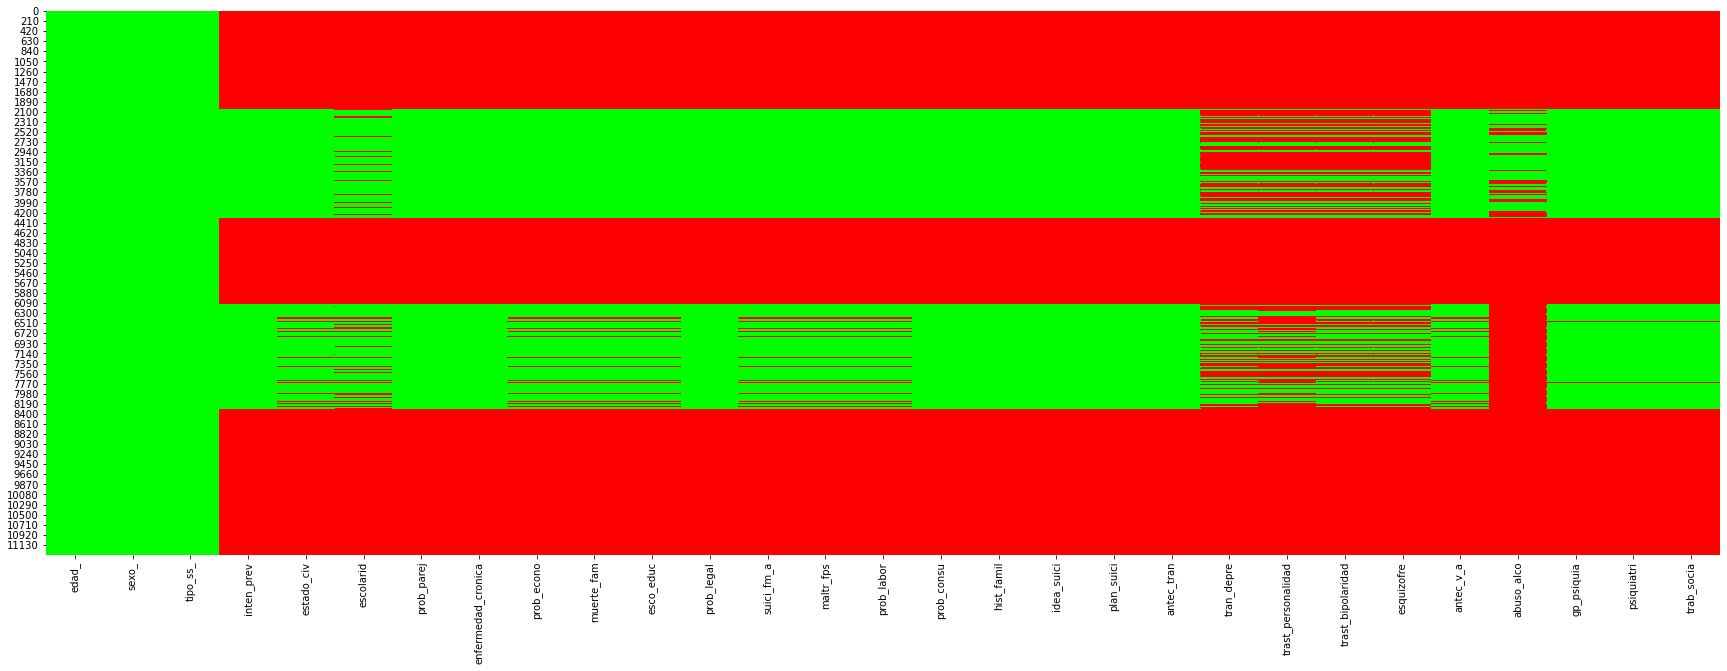

In [9]:
cols = df_suicidio.columns[:]
colours = ['#00FF00', '#ff0000'] # specify the colours - red is missing. green is not missing.
fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
sns.heatmap(df_suicidio[cols].isnull(), cmap=sns.color_palette(colours), ax=ax,cbar=False)

#### Porcentaje de datos faltantes

In [10]:
for col in df_suicidio.columns:
    pct_missing = np.mean(df_suicidio[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

tipo_ss_ - 0.02%
inten_prev - 60.62%
estado_civ - 63.36%
escolarid - 66.99%
prob_parej - 60.6%
enfermedad_cronica - 60.6%
prob_econo - 63.36%
muerte_fam - 63.36%
esco_educ - 63.36%
prob_legal - 60.6%
suici_fm_a - 63.36%
maltr_fps - 63.36%
prob_labor - 63.36%
prob_consu - 60.6%
hist_famil - 60.6%
idea_suici - 60.6%
plan_suici - 60.6%
antec_tran - 60.61%
tran_depre - 81.53%
trast_personalidad - 84.38%
trast_bipolaridad - 81.53%
esquizofre - 81.52%
antec_v_a - 63.36%
abuso_alco - 85.41%
gp_psiquia - 61.44%
psiquiatri - 61.46%
trab_socia - 61.46%


#### Conteo de registros agrupados por datos faltantes

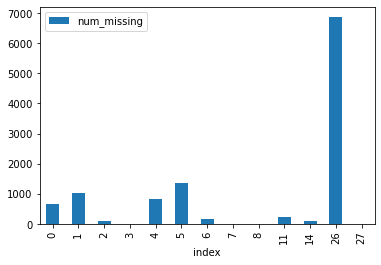

In [11]:
# first create missing indicator for features with missing data
for col in df_suicidio.columns:
    missing = df_suicidio[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
#         print('created missing indicator for: {}'.format(col))
        df_suicidio['{}_ismissing'.format(col)] = missing


# then based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in df_suicidio.columns if 'ismissing' in col]
df_suicidio['num_missing'] = df_suicidio[ismissing_cols].sum(axis=1)

df_suicidio['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

## Solucion
### 1. Eliminar registros con 11 o mas datos faltantes
### 2. Eliminar registros con informacion faltante en 'inten_prev'
### 3. Tratar columna con alto porcentaje de nulos, ya sea eliminandolas o imputando datos


In [12]:
# drop rows with a lot of missing values.
ind_missing = df_suicidio[df_suicidio['num_missing'] >= 11].index
df2 = df_suicidio.drop(ind_missing, axis=0)
df2.info()

## Previamente el filtro se estaba haciendo asi:
# df_filtered = df_suicidio[df_suicidio['fec_ocurr'] != '01/01/1900'] 
# aux2 =df_filtered
# aux2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4154 entries, 2048 to 8315
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad_                         4154 non-null   float64
 1   sexo_                         4154 non-null   object 
 2   tipo_ss_                      4154 non-null   object 
 3   inten_prev                    4152 non-null   float64
 4   estado_civ                    4154 non-null   float64
 5   escolarid                     3742 non-null   float64
 6   prob_parej                    4154 non-null   float64
 7   enfermedad_cronica            4154 non-null   float64
 8   prob_econo                    4154 non-null   float64
 9   muerte_fam                    4154 non-null   float64
 10  esco_educ                     4154 non-null   float64
 11  prob_legal                    4154 non-null   float64
 12  suici_fm_a                    4154 non-null   float64
 13  

In [13]:
df2['inten_prev'].value_counts(dropna=False)

2.0    2548
1.0    1603
NaN       2
4.0       1
Name: inten_prev, dtype: int64

In [14]:
df2 = df2[df2['inten_prev'].notnull()]
df2 = df2[df2['inten_prev'] != 4] # 4 equivale a sin informacion, por lo tanto se elimina para contar en trodos los registros con un valor valido
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4151 entries, 2048 to 8315
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad_                         4151 non-null   float64
 1   sexo_                         4151 non-null   object 
 2   tipo_ss_                      4151 non-null   object 
 3   inten_prev                    4151 non-null   float64
 4   estado_civ                    4151 non-null   float64
 5   escolarid                     3739 non-null   float64
 6   prob_parej                    4151 non-null   float64
 7   enfermedad_cronica            4151 non-null   float64
 8   prob_econo                    4151 non-null   float64
 9   muerte_fam                    4151 non-null   float64
 10  esco_educ                     4151 non-null   float64
 11  prob_legal                    4151 non-null   float64
 12  suici_fm_a                    4151 non-null   float64
 13  

#### Revisamos los datos de nuevo

In [15]:
# df2['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')
# df2['num_missing'].value_counts(dropna=False)

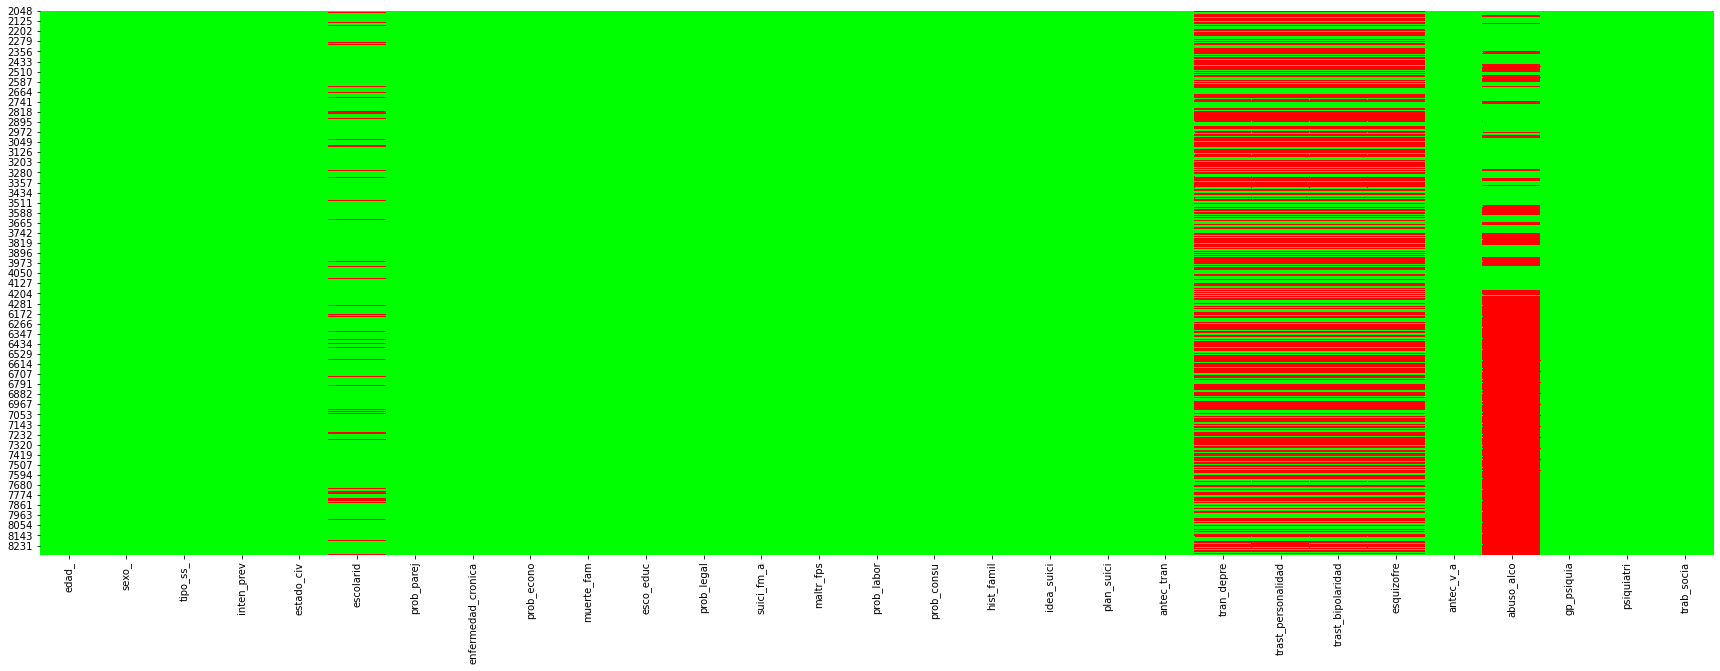

In [16]:
fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
cols = df2.columns[:columns_number]
sns.heatmap(df2[cols].isnull(), cmap=sns.color_palette(colours), ax=ax, cbar=False)

In [17]:
for col in df2.columns:
    pct_missing = np.mean(df2[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

escolarid - 9.93%
tran_depre - 57.12%
trast_personalidad - 57.38%
trast_bipolaridad - 57.12%
esquizofre - 57.12%
abuso_alco - 60.23%
gp_psiquia - 0.14%
psiquiatri - 0.19%
trab_socia - 0.19%


In [18]:
df2.iloc[:,:columns_number]

,edad_,sexo_,tipo_ss_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,...,antec_tran,tran_depre,trast_personalidad,trast_bipolaridad,esquizofre,antec_v_a,abuso_alco,gp_psiquia,psiquiatri,trab_socia
2048,24.0,F,S,1.0,2.0,3.0,1.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2049,30.0,M,S,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,1.0
2050,20.0,F,C,1.0,1.0,9.0,2.0,2.0,2.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
2051,23.0,F,S,2.0,1.0,3.0,1.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,2.0
2052,62.0,M,S,2.0,2.0,NaN,2.0,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,17.0,F,C,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,2.0
8311,17.0,F,C,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0
8312,17.0,F,C,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,2.0,2.0
8313,17.0,F,C,2.0,1.0,9.0,2.0,2.0,2.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0


### Nota
En este punto nos presentamos ante tres opciones: 
1. Eliminar aquella columnas que presentan alto numero de valores nulos (tran_depre, trast_personalidad, trast_bipolaridad, esquizofre, abuso_alco), ya que al ser tan altos no seria razonable imputar datos
2. Depurar aun mas los datos y reducir "drasticamente" el volumne de resgistros con respecto al original pero conservando algunas caracteristicas que consideramos podrian ser relevantes para la prediccion 
3. Imputar dichos valores nulos, aun cuando son mayoria

Se obtendran tres datasets(cds_few, cds, cds_imputed), cada uno aplicando una opcion, para comparalrlos en siguientes etapas al desarrrollar los modelos.

Primero se procede a detectar outliers, valores no validos y terminar de etiquetar y limpiar los datos para que lo uiltom a realizar sea separarlo segun se comento anteriormente.

## Deteccion de outliers y valores no validos
El unico dato realmente numerico es edad, en su diagrama de cajase observaque hya alguno valores muy alejados del promedio, pero segun lo que significa para el contexto los coonsideramos como validos

Para las demas columnas(categoricas) se realiza la grafica de barra para conocer su distribucion y si existe algun dato no valido. Tal es el caso para 'escolarid', en el cual se presentan algunas con valor en 6, estos registros se proceden a eliminar


edad_


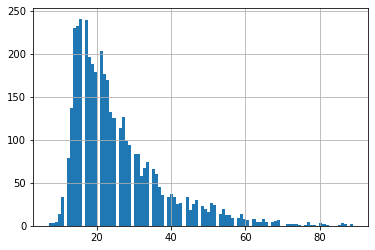

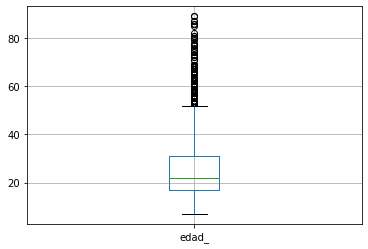

sexo_


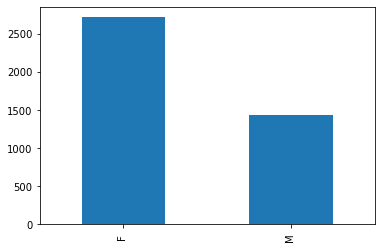

tipo_ss_


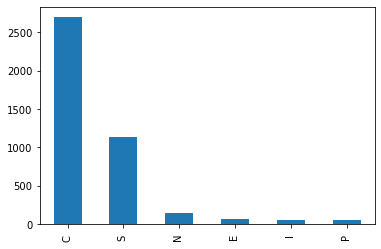

inten_prev


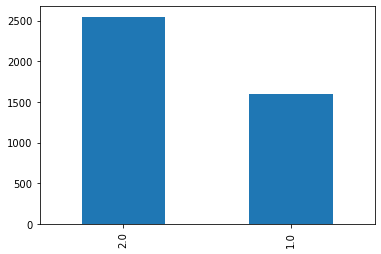

estado_civ


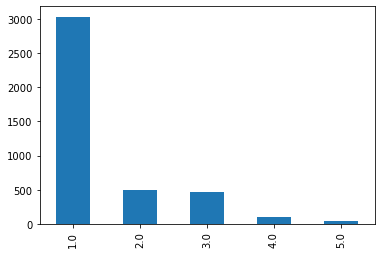

escolarid


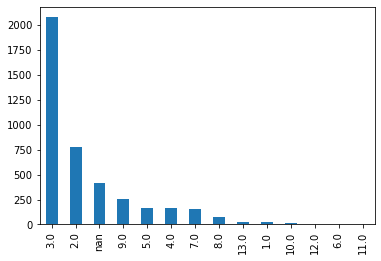

prob_parej


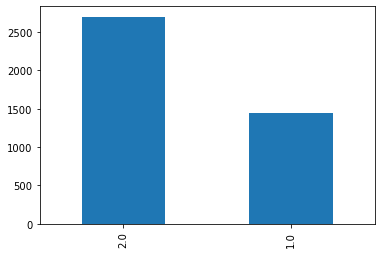

enfermedad_cronica


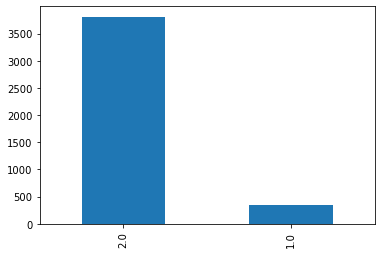

prob_econo


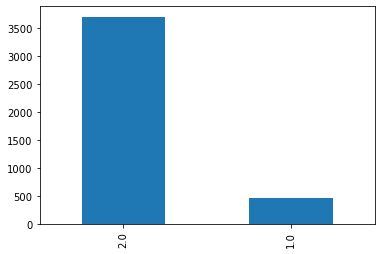

muerte_fam


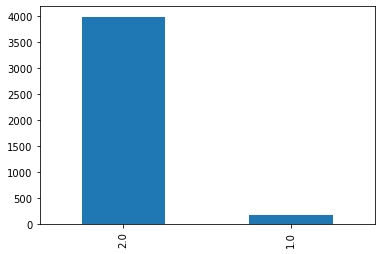

esco_educ


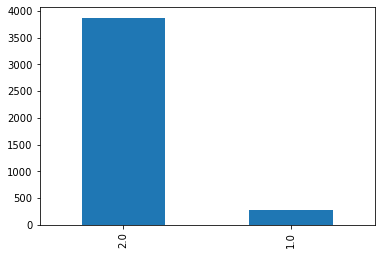

prob_legal


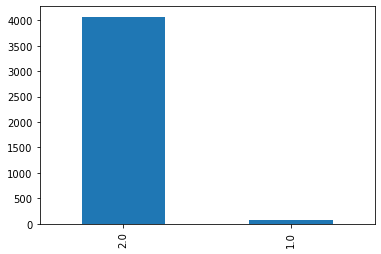

suici_fm_a


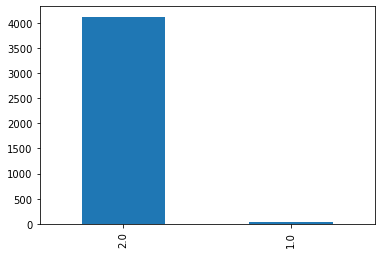

maltr_fps


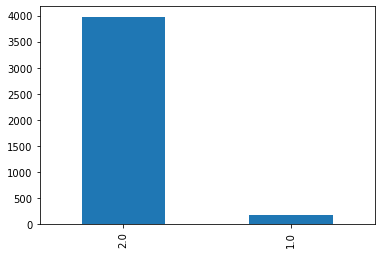

prob_labor


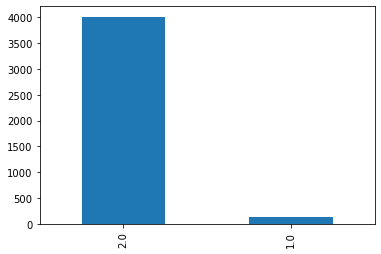

prob_consu


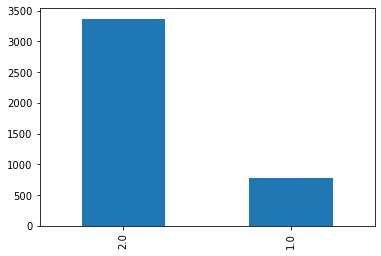

hist_famil


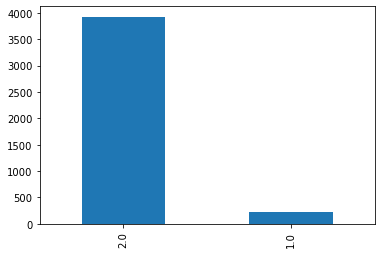

idea_suici


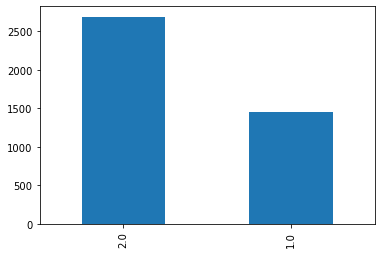

plan_suici


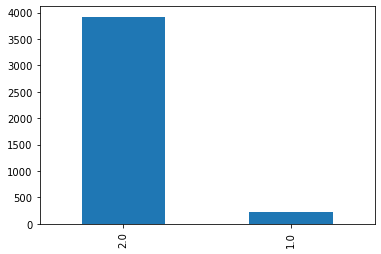

antec_tran


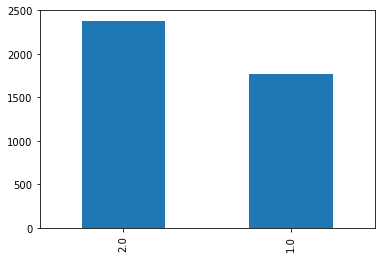

tran_depre


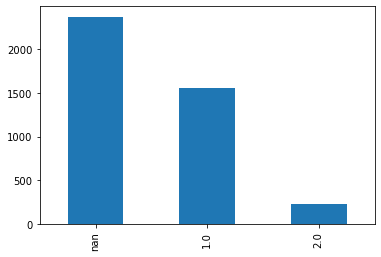

trast_personalidad


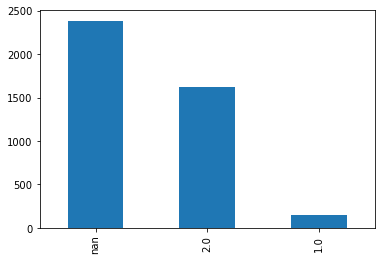

trast_bipolaridad


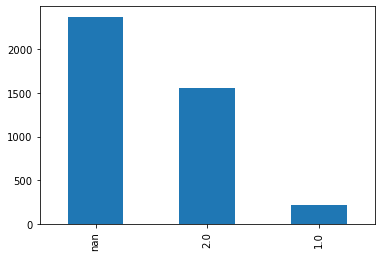

esquizofre


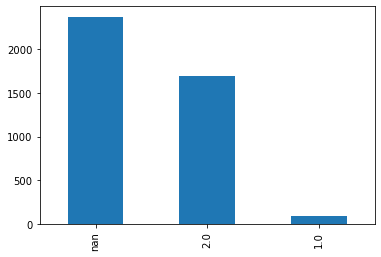

antec_v_a


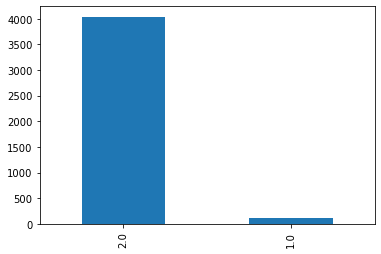

abuso_alco


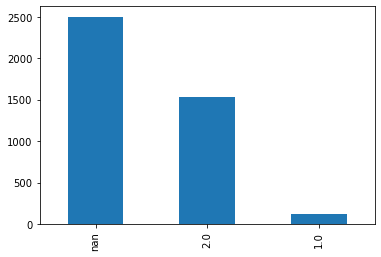

gp_psiquia


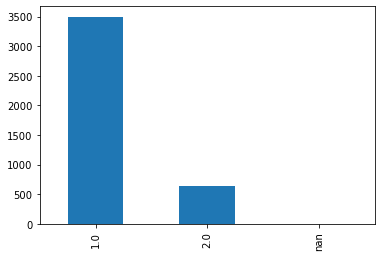

psiquiatri


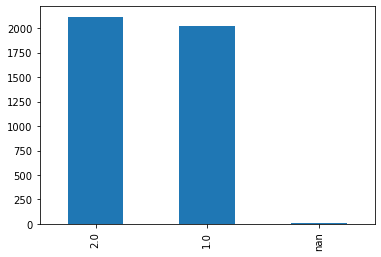

trab_socia


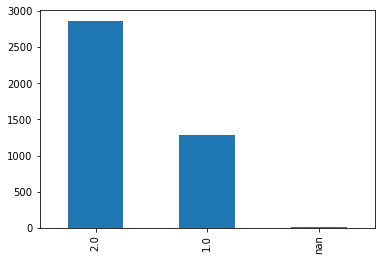

In [19]:
print('edad_')
df2['edad_'].hist(bins=100)
plt.plot()
plt.show()
df2.boxplot(column=['edad_'])
plt.plot()
plt.show()
for col in df2.columns:
    if( col[-7:] != 'missing' and col != 'edad_'):
        print(col)
        df2[col].value_counts(dropna= False).plot.bar()
        plt.plot()
        plt.show()

In [20]:
df2 = df2[df2['escolarid'] != 6] #Segun la documentacion del data set, 6 no es posible en esta columna

## Labeling- Encoding
Inicialmente los valores posibles que tienen las columnas son:

'edad_' -> numero

'sexo_' -> M, F

'tipo_ss_' -> C= Contributivo, S=Subsidiado, P=Excepción, E=Especial, N= No asegurado, I= Indeterminado/Pendiente

'estado_civ' -> 1= Soltero(a), 2=Casado(a), 3= Unión libre, 4= Viudo(a), 5= Divorciado(a)

'escolarid' -> 1= Preescolar, 2= Básica primaria, 3= Básica secundaria, 5= Media técnica, 7= Técnica profesional, 8= Tecnológica o técnica, 9= Profesional, 10= Especialización, 11= Maestría, 12= Doctorado, 13= Ninguno, 14= Sin información

['inten_prev', 'prob_parej', 'enfermedad_cronica', 'prob_econo', 'muerte_fam', 'esco_educ', 'prob_legal', 'suici_fm_a', 'maltr_fps', 'prob_labor', 'prob_consu', 'hist_famil', 'idea_suici', 'plan_suici', 'antec_tran', 'tran_depre', 'trast_personalidad', 'trast_bipolaridad', 'esquizofre', 'antec_v_a', 'abuso_alco', 'gp_psiquia', 'psiquiatri', 'trab_socia'] -> 1= Si, 2= No

La mayoria de columna son categoricas, pero el dataset obtenido ya las tenia codificadas, por lo tanto se usara asi, pero donde sea necesario se cambiaran algunas etiquetas y se codificaran aquellas que lo necesiten

'sexo_'-> binary encoding M:0 F:1

'tipo_ss_'-> se utilizara one hot encoding

Las demas se usaran tsal y como estan

In [21]:
nominal_features = pd.get_dummies(df2['tipo_ss_'], prefix="tipo_ss")
nominal_features

,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2048,0,0,0,0,0,1
2049,0,0,0,0,0,1
2050,1,0,0,0,0,0
2051,0,0,0,0,0,1
2052,0,0,0,0,0,1
...,...,...,...,...,...,...
8309,1,0,0,0,0,0
8311,1,0,0,0,0,0
8312,1,0,0,0,0,0
8313,1,0,0,0,0,0


In [22]:
df2['sexo_'].replace({'M':0, 'F':1}, inplace= True,  regex=True)
df2 = df2.join(nominal_features)
df2 = df2.drop('tipo_ss_', axis=1)
df2

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,gp_psiquia_ismissing,psiquiatri_ismissing,trab_socia_ismissing,num_missing,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2048,24.0,1,1.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,...,False,False,False,4,0,0,0,0,0,1
2049,30.0,0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,False,False,False,4,0,0,0,0,0,1
2050,20.0,1,1.0,1.0,9.0,2.0,2.0,2.0,1.0,2.0,...,False,False,False,0,1,0,0,0,0,0
2051,23.0,1,2.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,...,False,False,False,4,0,0,0,0,0,1
2052,62.0,0,2.0,2.0,NaN,2.0,2.0,1.0,2.0,2.0,...,False,False,False,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,...,False,False,False,1,1,0,0,0,0,0
8311,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,...,False,False,False,5,1,0,0,0,0,0
8312,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,...,False,False,False,5,1,0,0,0,0,0
8313,17.0,1,2.0,1.0,9.0,2.0,2.0,2.0,2.0,1.0,...,False,False,False,5,1,0,0,0,0,0


### Imputacion 
A las columnas [gp_psiquia, psiquiatri, trab_socia] se les realiza una imputacion simple de datos usando la mediana

In [23]:
impute = ['gp_psiquia', 'psiquiatri', 'trab_socia']
for col in impute:    
    med = df2[col].median()
#     print(med)
    df2[col] = df2[col].fillna(med)

In [24]:
for col in df2.columns:
    pct_missing = np.mean(df2[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

escolarid - 9.94%
tran_depre - 57.09%
trast_personalidad - 57.36%
trast_bipolaridad - 57.09%
esquizofre - 57.09%
abuso_alco - 60.18%


### Obtencion de cds_imputed e imputacion para escolarid
Se realizara una imputacion iterativa(multivariante i.e. se tienen en cuenta las otras columnas para imputar), desde aqui saldra el dataset cds_imputed, y adicionalmente tomaremos la columna escolarid para los otros dos data set.

In [25]:
to_drop = []
for col in df2.columns:
    if(col[-7:] == 'missing'):
        to_drop.append(col)        
to_drop
df2 =df2.drop(to_drop, axis=1)
df2

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,abuso_alco,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
2048,24.0,1,1.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,0,0,0,0,0,1
2049,30.0,0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,1.0,0,0,0,0,0,1
2050,20.0,1,1.0,1.0,9.0,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,1.0,2.0,1,0,0,0,0,0
2051,23.0,1,2.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,...,2.0,1.0,1.0,2.0,0,0,0,0,0,1
2052,62.0,0,2.0,2.0,NaN,2.0,2.0,1.0,2.0,2.0,...,1.0,1.0,1.0,1.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,...,NaN,1.0,2.0,2.0,1,0,0,0,0,0
8311,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,...,NaN,2.0,1.0,2.0,1,0,0,0,0,0
8312,17.0,1,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,...,NaN,1.0,2.0,2.0,1,0,0,0,0,0
8313,17.0,1,2.0,1.0,9.0,2.0,2.0,2.0,2.0,1.0,...,NaN,2.0,1.0,2.0,1,0,0,0,0,0


In [40]:
#En construccion desde aca hjacia abajo

In [38]:
imputer = IterativeImputer()
# fit on the dataset
imputer.fit(df2)
# transform the dataset
Xtrans = imputer.transform(df2)
cds_imputed = pd.DataFrame(Xtrans, columns = df2.columns)
cds_imputed

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,abuso_alco,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
0,24.0,1.0,1.0,2.0,3.000000,1.0,2.0,2.0,2.0,1.0,...,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,30.0,0.0,2.0,1.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,2.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,20.0,1.0,1.0,1.0,9.000000,2.0,2.0,2.0,1.0,2.0,...,2.000000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,23.0,1.0,2.0,1.0,3.000000,1.0,2.0,2.0,2.0,2.0,...,2.000000,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
4,62.0,0.0,2.0,2.0,3.410817,2.0,2.0,1.0,2.0,2.0,...,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,2.0,...,1.923369,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4142,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,1.0,...,1.866564,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4143,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,2.0,...,2.109814,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4144,17.0,1.0,2.0,1.0,9.000000,2.0,2.0,2.0,2.0,1.0,...,1.994973,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [39]:
imputer2 = IterativeImputer(initial_strategy='most_frequent')
# fit on the dataset
imputer2.fit(df2)
# transform the dataset
Xtrans2 = imputer2.transform(df2)
cds_imputed2 = pd.DataFrame(Xtrans2, columns = df2.columns)
cds_imputed2

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,abuso_alco,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
0,24.0,1.0,1.0,2.0,3.000000,1.0,2.0,2.0,2.0,1.0,...,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,30.0,0.0,2.0,1.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,2.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,20.0,1.0,1.0,1.0,9.000000,2.0,2.0,2.0,1.0,2.0,...,2.000000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,23.0,1.0,2.0,1.0,3.000000,1.0,2.0,2.0,2.0,2.0,...,2.000000,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
4,62.0,0.0,2.0,2.0,3.412165,2.0,2.0,1.0,2.0,2.0,...,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,2.0,...,1.923042,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4142,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,1.0,...,1.866566,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4143,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,2.0,...,2.109756,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4144,17.0,1.0,2.0,1.0,9.000000,2.0,2.0,2.0,2.0,1.0,...,1.994974,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
cds_imputed

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,abuso_alco,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
0,24.0,1.0,1.0,2.0,3.000000,1.0,2.0,2.0,2.0,1.0,...,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,30.0,0.0,2.0,1.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,2.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,20.0,1.0,1.0,1.0,9.000000,2.0,2.0,2.0,1.0,2.0,...,2.000000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,23.0,1.0,2.0,1.0,3.000000,1.0,2.0,2.0,2.0,2.0,...,2.000000,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
4,62.0,0.0,2.0,2.0,3.412165,2.0,2.0,1.0,2.0,2.0,...,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,2.0,...,1.923042,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4142,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,1.0,...,1.866566,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4143,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,2.0,...,2.109756,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4144,17.0,1.0,2.0,1.0,9.000000,2.0,2.0,2.0,2.0,1.0,...,1.994974,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:
imp = Imputer(missing_values=0, strategy="mean", axis=0)
df["C"] = imp.fit_transform(df[["C"]]).ravel()

NameError: name 'Imputer' is not defined

In [37]:
aux10= pd.DataFrame(Xtrans, columns = df2.columns)
aux10

,edad_,sexo_,inten_prev,estado_civ,escolarid,prob_parej,enfermedad_cronica,prob_econo,muerte_fam,esco_educ,...,abuso_alco,gp_psiquia,psiquiatri,trab_socia,tipo_ss_C,tipo_ss_E,tipo_ss_I,tipo_ss_N,tipo_ss_P,tipo_ss_S
0,24.0,1.0,1.0,2.0,3.000000,1.0,2.0,2.0,2.0,1.0,...,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,30.0,0.0,2.0,1.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,2.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,20.0,1.0,1.0,1.0,9.000000,2.0,2.0,2.0,1.0,2.0,...,2.000000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,23.0,1.0,2.0,1.0,3.000000,1.0,2.0,2.0,2.0,2.0,...,2.000000,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
4,62.0,0.0,2.0,2.0,3.412165,2.0,2.0,1.0,2.0,2.0,...,1.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,2.0,...,1.923042,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4142,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,1.0,...,1.866566,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4143,17.0,1.0,1.0,1.0,3.000000,2.0,2.0,2.0,2.0,2.0,...,2.109756,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
4144,17.0,1.0,2.0,1.0,9.000000,2.0,2.0,2.0,2.0,1.0,...,1.994974,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for col in aux10.columns:
    print(col)
    print(aux10[col].value_counts())
    pct_missing = np.mean(aux10[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

In [ ]:
# df2.columns[:columns_number]
df2['escolarid'].value_counts(dropna=False)
#pilas que hay que limpiar escolaridad
#6 no es valor valor valido

# Rivera


In [ ]:
from numpy import ones,vstack
from numpy.linalg import lstsq
points = [(2017,1862),(2018,2263)]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]
print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

In [ ]:
df_aux=pd.read_csv("suicidio2.csv", delimiter = ';')
titles_aux = df_aux.columns
arr_aux = []
for i in titles_aux:
    arr_aux.append(i[21:])

df_aux.columns = arr_aux

En esta limpieza también se realiza un primer filtro de características
- "X" e "Y" corresponden a la latitud y longitud de el accidente, dificilmente un accidente pueda ocurrir
en las mismas coordenadas, no se considera util.
- "OBJECTID" Es la clave primaria dentro de una base de datos mongo por lo que no es una carecterística
- "RADICADO" Es un valor único con el que se radicó cada accidente por lo tanto no es relevante
- "FECHA" los datasets ya cuentan con una fecha desglosada en mes y día.
- "MES_NOMBRE" no todas las filas tienen completo este campo, además de que ya se cuenta con una columna "MES" con
el número del mes.
- "DIRECCION_ENC" es otro formato para la dirección, por lo que se puede descartar.

Lo siguiente es verificar la presencia de datos atípicos o mal escritos en las clases
y sean reemplazados manualmente en un archivo csv.


In [ ]:
dataTotal=pd.concat(datalist,axis=0)
# print(dataTotal.columns)
dia_nombre=dataTotal['DIA_NOMBRE'].unique()
clase=dataTotal['CLASE'].unique()
tipo_geocod=dataTotal['TIPO_GEOCOD'].unique()
gravedad=dataTotal['GRAVEDAD'].unique()
barrio=dataTotal['BARRIO'].unique()
comuna=dataTotal['COMUNA'].unique()
mes=dataTotal['MES'].unique()
dia=dataTotal['DIA'].unique()
diseno=dataTotal['DISENO'].unique()
print(barrio)

In [ ]:
dataTotal.to_csv('dataTotal.csv')


La limpieza manual se hizo con la ayuda de una lista de valores únicos en cada columna donde se verificó
uno por uno que estuviera bien escrito y si existían valores que se estuvieran refiriendo a lo mismo como era el
caso de la columna "BARRIO" donde hallámos valores "San Antonio de parado" y "Corregimiento san antonio de prado"
que se referían al mismo pero que al codificarse posteriormente son interpretados conmo distintos.

Una vez que se hizo una limpieza manual de datos de clases mal escritos, cargamos nuevamente el dataset


In [ ]:
dataTotal2=pd.read_csv("dataTotalv2.csv")

Durante la limpieza manual de se omitieron valores atípicos encontrados para las columnas de "BARRIO" y "COMUNA"
donde habían valores como: 'Sin Nombre','0','Inst','AUC1' entre otros para buscar cuántas filas los contenian
y tomar decisiones sobre que hacer con ellos.
Estos datos atípicos tuvieron pocas apareiciones 2 o 3 por cada uno, por lo que se tomó la decisión de eliminar
la fila que los contenía.


In [ ]:
column=['BARRIO','COMUNA']
atypical=[['Sin Nombre','0','Inst','AUC1','6001','9086','7001','9004'],['AU','Sin Inf']]
a=zip(column,atypical)

#borra los datos atípicos de la segunda versión del dataset
for i ,j in a:
    for k in j:
        dataTotal2 = dataTotal2.drop(dataTotal2[dataTotal2[i] ==k].index)

In [ ]:
import matplotlib.pyplot as plt
nan_columns = []
nan_values = []

for column in dataTotal2.columns:
    b=dataTotal2[column].isnull().sum();
    if b>0:
        nan_columns.append(column)
        nan_values.append(b)

fig, ax = plt.subplots(figsize=(10,5))
plt.title('NaN por columna, total='+ str(dataTotal2.isnull().sum().sum()))
plt.bar(nan_columns, nan_values)

print(dataTotal2.isnull().sum().sum())

En el gráfico anterior se aprecian los valores nulos (NaN) por cada columna que los contiene
para un total de 736 que si bien es un número pequeño comparado con el total de datos de 113.659
se optó por rellenarlos en lugar de elimarlos, la estratégia a usar para esto fue la de 'most_frequent' que
por su traducción al español completa con el valor más frecuente en cada columna.

In [ ]:
#datos nulos
from sklearn.impute import SimpleImputer
print(dataTotal2.isnull().sum())
strategy = SimpleImputer(strategy='most_frequent')
dataTotalF=strategy.fit_transform(dataTotal2)
print(dataTotalF)

In [ ]:
newDf = pd.DataFrame(data=dataTotalF, columns=dataTotal2.columns)
print(newDf.isnull().sum())

# El dataset se encuentra sin datos atípicos o extraños.

In [ ]:
newDf.to_csv('cleanData.csv',index=False)

